In [15]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

# Overview of the data

The goal here is to find out which of the roughly 120000 files are useful for further analysis. In particular, I need to find out:

* Which stations collect data on precipitation (and how thoroughly)?
* What is the most densely populated time frame?
* How are the stations scattered accross the globe?
* Do they have further columns in common?

## Which stations collect data on precipitation?

In [2]:
datadir = os.path.join("..", "data", "ghcnd", "data_overview.csv")
figdir = os.path.join("..", "figures")

overview = pd.read_csv(datadir, parse_dates=["start_date", "end_date"], 
                       na_values=[-9999])
print(overview.shape)

(631772, 7)


Additionally, the early time periods are not too interesting, so maybe we can cut down on some computation time.

In [3]:
overview["na_share"] = overview.na_count / overview.nrow
overview.sort_values("end_date", inplace=True)
timediff = overview["end_date"] - overview["start_date"]
overview["years_covered"] = timediff / np.timedelta64(1, "Y")

end_date = pd.to_datetime("2000-01-01")

prcp = overview.loc[(overview.column == "PRCP") & (overview.end_date > end_date)].copy()
prcp.set_index("station", inplace=True)
print(prcp.shape)
prcp.head()

(69732, 8)


,start_date,end_date,column,nrow,na_count,file,na_share,years_covered
station,,,,,,,,
ASN00093057,1998-06-01,2000-01-05,PRCP,153,17,ASN00093057.csv,0.111111,1.596200
CA002302680,1957-06-01,2000-01-09,PRCP,14890,2649,CA002302680.csv,0.177905,42.607309
ASN00033067,1910-10-01,2000-01-11,PRCP,30517,534,ASN00033067.csv,0.017498,89.280410
ASN00093054,1995-11-24,2000-01-14,PRCP,296,14,ASN00093054.csv,0.047297,4.139715
ASN00003006,1893-03-01,2000-01-15,PRCP,35196,156,ASN00003006.csv,0.004432,106.874200


## What is the most densely populated time frame?

Start by creating a datetime index that covers both the start and the end of the observed period.

In [4]:
min_date = prcp.start_date.min()
max_date = prcp.end_date.max()
idx = pd.date_range(min_date, max_date, freq='Y')

Next we create a function that creates a `pd.Series` of `True` for the given `start` and `end` dates' year. Subsequently the series will be reindexed, such that its indices match up with `idx`. If the original series did not contain a date in `ìdx` it will be created and filled with `False`.

In [5]:
def check_time_range(start, end):
    """Create a logical array indicating if a station observed values in a given year."""
    series = pd.Series(True, index=pd.date_range(start, end, freq="Y"))
    series = series.reindex(idx, fill_value=False)
    return series

In [91]:
dates = prcp.apply(lambda x: check_time_range(x["start_date"], x["end_date"]), 1).T
dates.head()

station,ASN00093057,CA002302680,ASN00033067,ASN00093054,ASN00003006,USW00003929,ASN00005058,BR001956003,CA001123990,BR001655002,...,CA1NB000060,US1NJCM0029,US1TXGP0120,US1MOBN0063,US1TNTP0003,US1GASR0003,US1KYOH0009,US1NJBT0071,USC00319555,USC00111329
1763-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1764-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1765-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1766-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1767-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


With this, we can sum up accross the index, to obtain the total number of stations that provide observations on rainfall data. Keep in mind that this does not indicate how many missing values are to be expected. Neither does it reflect the geographical position of the stations.

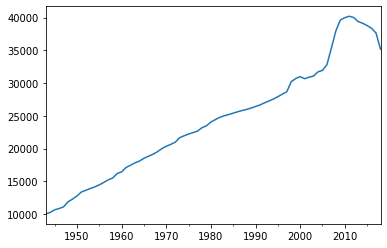

In [14]:
num_stations_per_year = dates.sum(axis=1)
num_stations_per_year[num_stations_per_year > 10000].plot();

It seems that there has been a steady rise in the number of stations that report precipitiation. That is a good thing. I might focus on the period between 1990 and 2016. I assume that the dip is kind of associated with Trump cutting the budget for climate-observation.

In [75]:
min_year = pd.to_datetime("1990-01-01")
max_year = pd.to_datetime("2018-01-31")
data = overview.loc[(overview.column=="PRCP") & 
                    (overview.start_date >= min_year) & 
                    (overview.years_covered >= 5) &
                    (overview.na_share < 0.1)]

In [76]:
print(data.shape)
data.head()

(22240, 9)


,station,start_date,end_date,column,nrow,na_count,file,na_share,years_covered
576922,CA006053575,1990-04-01,1995-07-31,PRCP,1948,91,CA006053575.csv,0.046715,5.330705
608946,ASN00003081,1990-04-01,1995-07-31,PRCP,1918,0,ASN00003081.csv,0.000000,5.330705
595937,CA008203520,1990-05-01,1995-11-30,PRCP,1693,27,CA008203520.csv,0.015948,5.582592
605522,MXN00024080,1990-01-01,1995-11-30,PRCP,1976,1,MXN00024080.csv,0.000506,5.911141
557881,UY000002337,1990-01-13,1995-12-31,PRCP,1980,0,UY000002337.csv,0.000000,5.963161


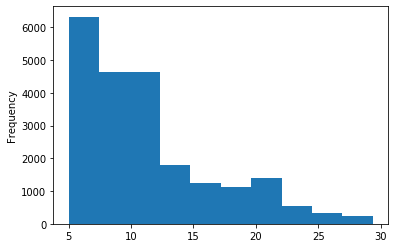

In [77]:
data.years_covered.plot.hist()

In [78]:
data.station.str[:2].unique()

array(['CA', 'AS', 'MX', 'UY', 'BR', 'US', 'VE', 'SW', 'FI', 'GM', 'FM',
       'NL', 'IS', 'GR', 'IT', 'DA', 'UZ', 'RQ', 'AG', 'UK', 'NO', 'SP',
       'RS', 'BG', 'SI', 'RM', 'CQ', 'PS', 'VQ', 'EC', 'FR', 'TD', 'CE',
       'VM', 'BF', 'GQ'], dtype=object)

In [80]:
data.start_date.dt.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014])

In [81]:
overview[overview.station.str[:2] == "GR"]

,station,start_date,end_date,column,nrow,na_count,file,na_share,years_covered
518107,GRE00155825,1998-01-02,2004-09-15,TMAX,2449,0,GRE00155825.csv,0.000000,6.702396
518106,GRE00155825,1998-01-02,2004-09-15,PRCP,2449,0,GRE00155825.csv,0.000000,6.702396
518108,GRE00155825,1998-01-02,2004-09-15,TMIN,2449,0,GRE00155825.csv,0.000000,6.702396
211770,GRW00033209,1975-11-01,2004-09-30,WT05,8902,8884,GRW00033209.csv,0.997978,28.915036
211769,GRW00033209,1975-11-01,2004-09-30,WT04,8902,8873,GRW00033209.csv,0.996742,28.915036
211768,GRW00033209,1975-11-01,2004-09-30,WT03,8902,8604,GRW00033209.csv,0.966524,28.915036
211762,GRW00033209,1975-11-01,2004-09-30,WDF2,8902,8901,GRW00033209.csv,0.999888,28.915036
211767,GRW00033209,1975-11-01,2004-09-30,WT02,8902,8894,GRW00033209.csv,0.999101,28.915036
211764,GRW00033209,1975-11-01,2004-09-30,WSF2,8902,8901,GRW00033209.csv,0.999888,28.915036
211772,GRW00033209,1975-11-01,2004-09-30,WT08,8902,7705,GRW00033209.csv,0.865536,28.915036


In [92]:
prcp.apply(lambda x: (x["start_date"].year, x["end_date"].year), 1)

station
ASN00093057    (1998, 2000)
CA002302680    (1957, 2000)
ASN00033067    (1910, 2000)
ASN00093054    (1995, 2000)
ASN00003006    (1893, 2000)
USW00003929    (1954, 2000)
ASN00005058    (1967, 2000)
BR001956003    (1958, 2000)
CA001123990    (1952, 2000)
BR001655002    (1968, 2000)
USC00118690    (1969, 2000)
BR001556006    (1969, 2000)
CA003020676    (1982, 2000)
BR001954004    (1968, 2000)
ASN00014701    (1964, 2000)
BR001558000    (1971, 2000)
BR001557000    (1971, 2000)
BR001757001    (1968, 2000)
BR001457000    (1971, 2000)
BR001557001    (1968, 2000)
USC00101002    (1894, 2000)
CA005041587    (1969, 2000)
USC00258980    (1948, 2000)
ASN00078025    (1884, 2000)
BR001853005    (1984, 2000)
MXN00014373    (1985, 2000)
BR001557005    (1976, 2000)
MXN00014015    (1950, 2000)
USC00431360    (1893, 2000)
MXN00029061    (1990, 2000)
                   ...     
US1NCCT0039    (2017, 2019)
USC00182906    (1956, 2019)
US1TXLV0003    (2007, 2019)
US1TXWM0044    (2008, 2019)
US1ORLA0076 

In [18]:
candidates = [(a, b) for a in range(1900, 2019) for b in range(a, 2020)]

In [36]:
def get_num_stations_in_time_frame(df, start, end):
    out = df.loc[(df["start_date"].dt.year == start) & 
                 (df["end_date"].dt.year == end)].copy()
    return len(out)

In [38]:
counts = [(s, e, get_num_stations_in_time_frame(prcp, s, e)) for s, e in tqdm_notebook(candidates, leave=False)]
num_stations = pd.DataFrame(counts, columns=["start", "end", "counts"]).sort_values("counts", ascending=False)
num_stations.head()

,start,end,counts
7258,2018,2019,1640
7256,2017,2019,1587
7193,2008,2019,1523
7253,2016,2019,1441
7204,2009,2019,1370
